## Временные ряды
### Определение аномалий

Выполняем предварительную обработку датасета

In [19]:
import pandas as pd
import re
import csv

full_log = []
msg = []
param = []
pattern = r":\s"

with open("HDFS.log", "r") as f:
    for line in f:
        part = re.split(pattern, line[:-1], maxsplit=1)
        full_log.append(line[:-1])
        param.append(part[0])
        msg.append(part[1])

df = pd.DataFrame({'full_log': full_log,'param': param,'msg': msg})

param_df = df['param'].str.split(' ',expand=True)
param_df.columns=['date','time','pid','level','component']
df = pd.concat([df,param_df],axis=1)


In [20]:
def msg_blk_regex(msg):
    blk = re.findall(r"\s(blk_-?\d+)", msg)
    return blk[0]
     
df['blk'] = df['msg'].apply(msg_blk_regex)

In [21]:
anomaly = pd.read_csv("anomaly_label.csv")
df = pd.merge(df, anomaly, left_on = 'blk', right_on = 'BlockId', how = 'left')

In [22]:
df["datetime"] = pd.to_datetime(df["date"] + df["time"], format="%y%m%d%H%M%S")
df = df.set_index("datetime")
df = df.sort_index()

In [23]:
df.drop(['param', 'msg', 'date', 'time', 'pid', 'level', 'BlockId','component','blk','BlockId'], axis=1, inplace=True)
df.head()

,full_log,Label
datetime,,
2008-11-09 20:35:18,081109 203518 143 INFO dfs.DataNode$DataXceive...,Normal
2008-11-09 20:35:18,081109 203518 35 INFO dfs.FSNamesystem: BLOCK*...,Normal
2008-11-09 20:35:19,081109 203519 143 INFO dfs.DataNode$DataXceive...,Normal
2008-11-09 20:35:19,081109 203519 145 INFO dfs.DataNode$DataXceive...,Normal
2008-11-09 20:35:19,081109 203519 145 INFO dfs.DataNode$PacketResp...,Normal


In [24]:
df_min = df.resample('1min').agg({
    'full_log': 'count',
    'Label': lambda x: (x == 'Anomaly').sum()
})


df_min: датасет, где индекс - это 1 минута. "full_log" - количество логов за 1 минуту. "Label" - количество аномальных логов


In [25]:
df_min.head()

,full_log,Label
datetime,,
2008-11-09 20:35:00,2206,248
2008-11-09 20:36:00,7148,131
2008-11-09 20:37:00,7707,210
2008-11-09 20:38:00,7596,125
2008-11-09 20:39:00,7529,200


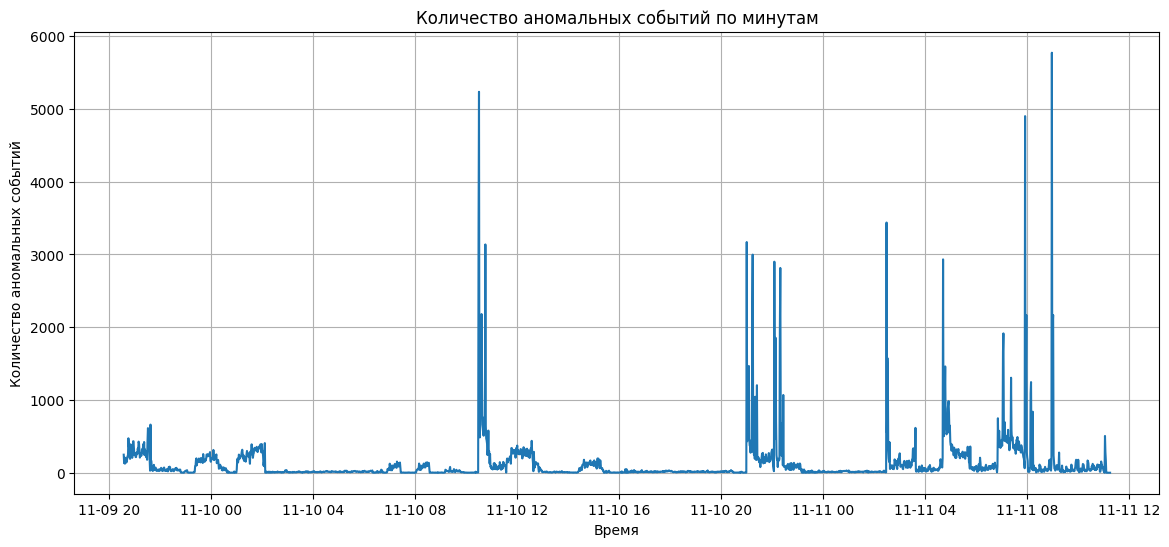

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=df_min,
    x=df_min.index,
    y='Label'
)

plt.title("Количество аномальных событий по минутам")
plt.xlabel("Время")
plt.ylabel("Количество аномальных событий")
plt.grid(True)
plt.show()

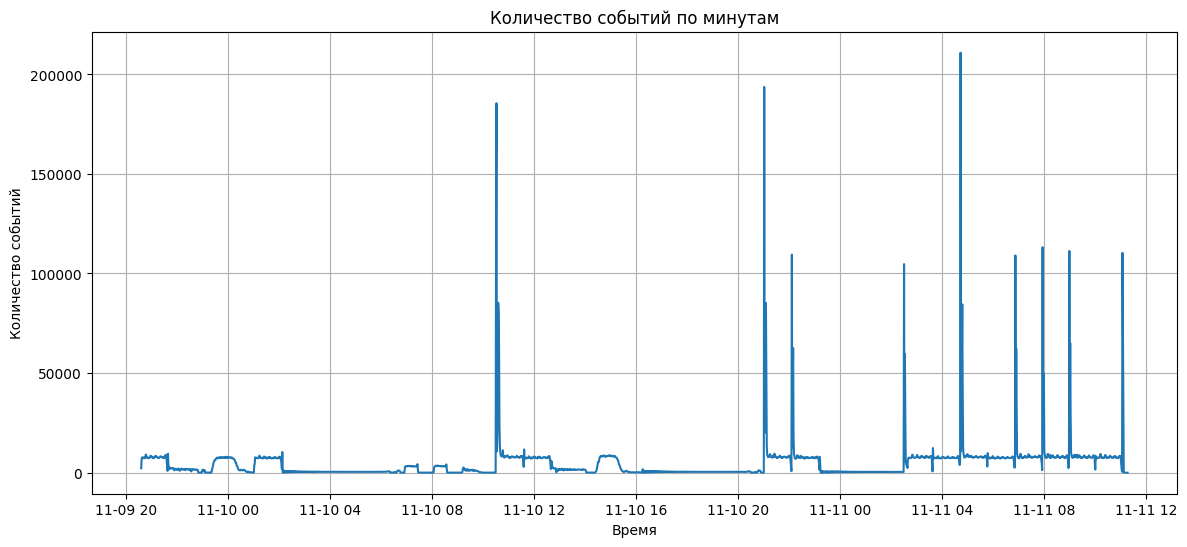

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=df_min,
    x=df_min.index,
    y='full_log'
)

plt.title("Количество событий по минутам")
plt.xlabel("Время")
plt.ylabel("Количество событий")
plt.grid(True)
plt.show()

Видно, что количество аномальных событий зависит от общего количества событий. Чем больше событий, тем больше аномалий. Количество аномалий не является тем фактором, которые значительно влияет на количество событий, что помогло бы определить подозрительные Аномальные всплески.

Однако, значительное повышение количества числа аномальных событий будем считать аномалией. Но необходимо подобрать порог аномального количества событий.

Разделяем датасет на тренировочный и тестовый:

In [44]:
split = int(len(df_min) * 0.8)

train = df_min.iloc[:split]
test  = df_min.iloc[split:]

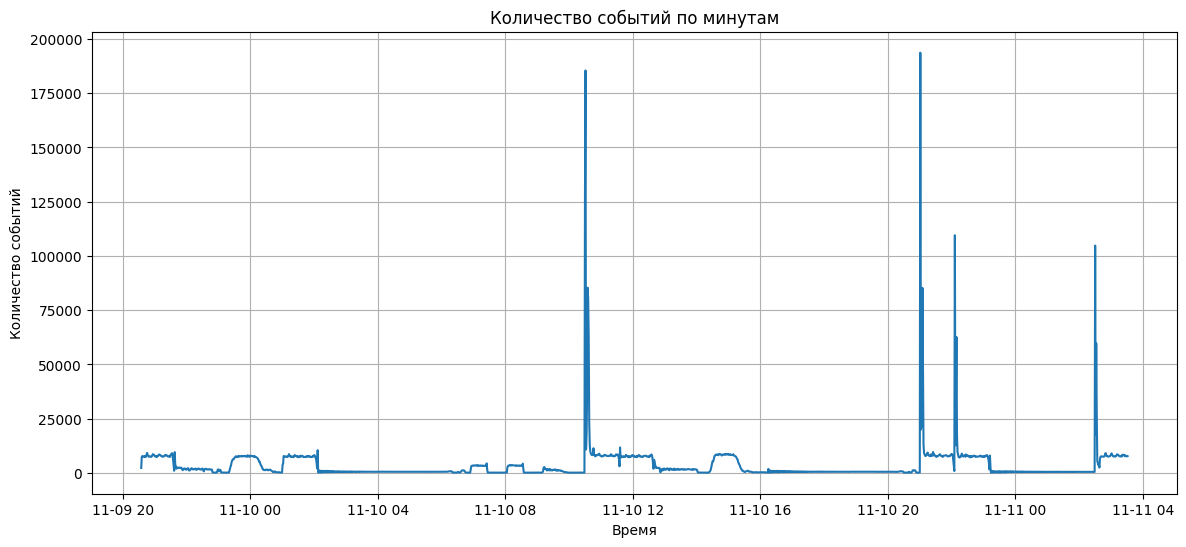

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=train,
    x=train.index,
    y='full_log'
)

plt.title("Количество событий по минутам")
plt.xlabel("Время")
plt.ylabel("Количество событий")
plt.grid(True)
plt.show()

Подбираем порог при котором считаем количество событий аномальным. Используем MAD.
При пороге 8778 (количество событий), процент аномальных минут примерно 2.5. 

Рассчеты (подбор):

In [46]:
import numpy as np

median = train['full_log'].median()
mad = np.median(np.abs(train['full_log'] - median))
count_events = len(train)

print("Медиана:", median)
for k in range(1,31):
    threshold = median + k * mad
    count_anomal = (train['full_log'] > threshold).sum()
    percent = (count_anomal/count_events) * 100

    print(f"k = {k} | Порог = {threshold} | Аномалий = {count_anomal} | Процент аномалий = {percent}" )

Медиана: 644.0
k = 1 | Порог = 1225.0 | Аномалий = 813 | Процент аномалий = 43.780290791599356
k = 2 | Порог = 1806.0 | Аномалий = 679 | Процент аномалий = 36.56435110393107
k = 3 | Порог = 2387.0 | Аномалий = 636 | Процент аномалий = 34.24878836833602
k = 4 | Порог = 2968.0 | Аномалий = 621 | Процент аномалий = 33.44103392568659
k = 5 | Порог = 3549.0 | Аномалий = 558 | Процент аномалий = 30.048465266558967
k = 6 | Порог = 4130.0 | Аномалий = 550 | Процент аномалий = 29.617662897145934
k = 7 | Порог = 4711.0 | Аномалий = 543 | Процент аномалий = 29.24071082390953
k = 8 | Порог = 5292.0 | Аномалий = 536 | Процент аномалий = 28.863758750673128
k = 9 | Порог = 5873.0 | Аномалий = 529 | Процент аномалий = 28.486806677436725
k = 10 | Порог = 6454.0 | Аномалий = 518 | Процент аномалий = 27.894453419493807
k = 11 | Порог = 7035.0 | Аномалий = 507 | Процент аномалий = 27.30210016155089
k = 12 | Порог = 7616.0 | Аномалий = 310 | Процент аномалий = 16.69359181475498
k = 13 | Порог = 8197.0 | Ан

Убираем аномалии из тренировочного сета, пропуски заполняем медианой нормальных значений.

In [47]:
median_n = train.loc[train['full_log'] <= 8778.0, 'full_log'].median()
train.loc[train['full_log'] > 8778.0, 'full_log'] = median_n

C:\Users\r.artyuhov\AppData\Local\Temp\ipykernel_2564\3717889397.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '584.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train['full_log'] > 8778.0, 'full_log'] = median_n


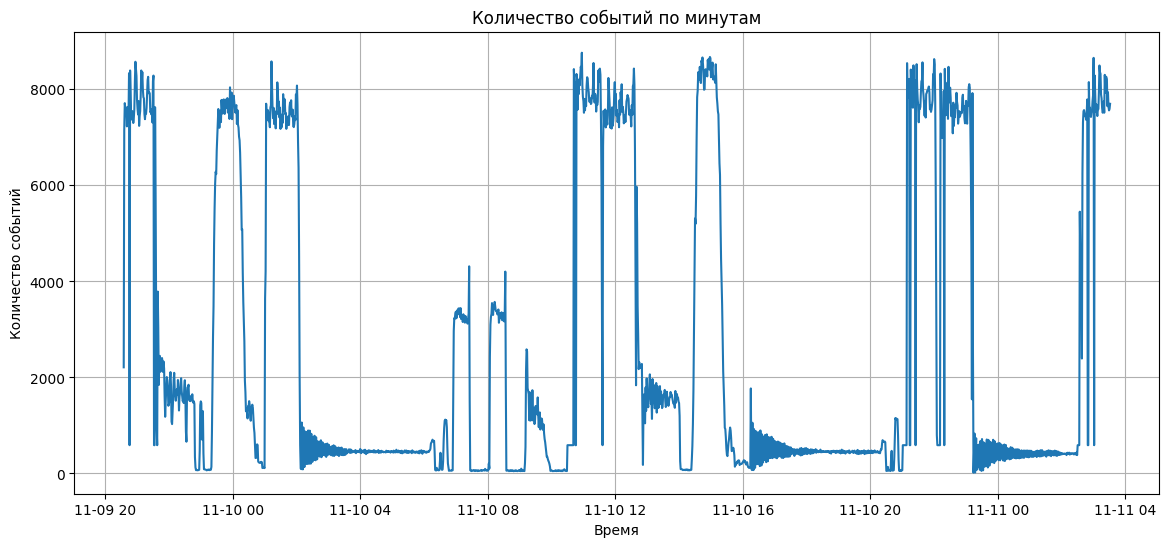

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=train,
    x=train.index,
    y='full_log'
)

plt.title("Количество событий по минутам")
plt.xlabel("Время")
plt.ylabel("Количество событий")
plt.grid(True)
plt.show()

Проводим тест на стационарность (Тест Дики — Фуллера). Наш ряд стационарен, можем применять ARIMA

In [50]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['full_log'])
print(result[1])

0.0002758943768118088


С помощью ARIMA будем предсказывать следующие 10 точек (10 минут). Нужно понять, на тренировочном сете, на каком "окне" лучше предсказывать (на каком количестве точек предсказываем следующие 10). 

In [75]:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error

ts = train['full_log']

for n in range(100, 161, 10):
    mae_list = []
    #шаг менялся для разных тестов, для увеличения скорости подбора
    for start in range(0, len(ts) - n - 10, 30):
        train_window = ts[start : start + n]
        target  = ts[start + n : start + n + 10]

        model = auto_arima(train_window, error_action="ignore")
        forecast = model.predict(n_periods=10)
        
        mae = mean_absolute_error(target, forecast)
        mae_list.append(mae)

    print(f"Window = {n} | MAE = {np.mean(mae_list)}" )

Window = 100 | MAE = 713.7439862312752
Window = 110 | MAE = 673.1127328240592
Window = 120 | MAE = 758.0074902271252
Window = 130 | MAE = 762.2858771961652
Window = 140 | MAE = 638.9687932010098
Window = 150 | MAE = 776.9707775951425
Window = 160 | MAE = 644.3606910771307


Скрипт выше использовался итерационно, чтобы выявить окно точнее. Как только MAE переставал уменьшаться в последующих шагах, то начиналась следующая итерация.
Были получены следующие результаты.
Шаг 1:
- Window = 60 | MAE = 1176.9377332793342
- Window = 300 | MAE = 516.4779599374349
- Window = 540 | MAE = 725.2875745894767
- Window = 780 | MAE = 616.3531071234053
- Window = 1020 | MAE = 534.8622885363195

Шаг 2:
- Window = 60 | MAE = 1176.9377332793342
- Window = 120 | MAE = 493.22538417429575
- Window = 180 | MAE = 908.5706786013739
- Window = 240 | MAE = 760.3557902488458
- Window = 300 | MAE = 516.4779599374349
- Window = 360 | MAE = 758.5837135543869

Шаг 3:
- Window = 90 | MAE = 959.7698479192366
- Window = 100 | MAE = 451.939407705055
- Window = 110 | MAE = 467.88743669917585
- Window = 120 | MAE = 493.22538417429575
- Window = 130 | MAE = 969.5229421706347
- Window = 140 | MAE = 435.9098293027072
- Window = 150 | MAE = 804.7584751627993
- Window = 160 | MAE = 343.9223130963126
- Window = 170 | MAE = 868.3104934636425

Шаг 4:
- Window = 100 | MAE = 713.7439862312752
- Window = 110 | MAE = 673.1127328240592
- Window = 120 | MAE = 758.0074902271252
- Window = 130 | MAE = 762.2858771961652
- Window = 140 | MAE = 638.9687932010098
- Window = 150 | MAE = 776.9707775951425
- Window = 160 | MAE = 644.3606910771307

Для различных тестов окно в 140 предыдущих точек показало лучший результат (по MAE)

#### Проведем тестирование на тестовой выборке

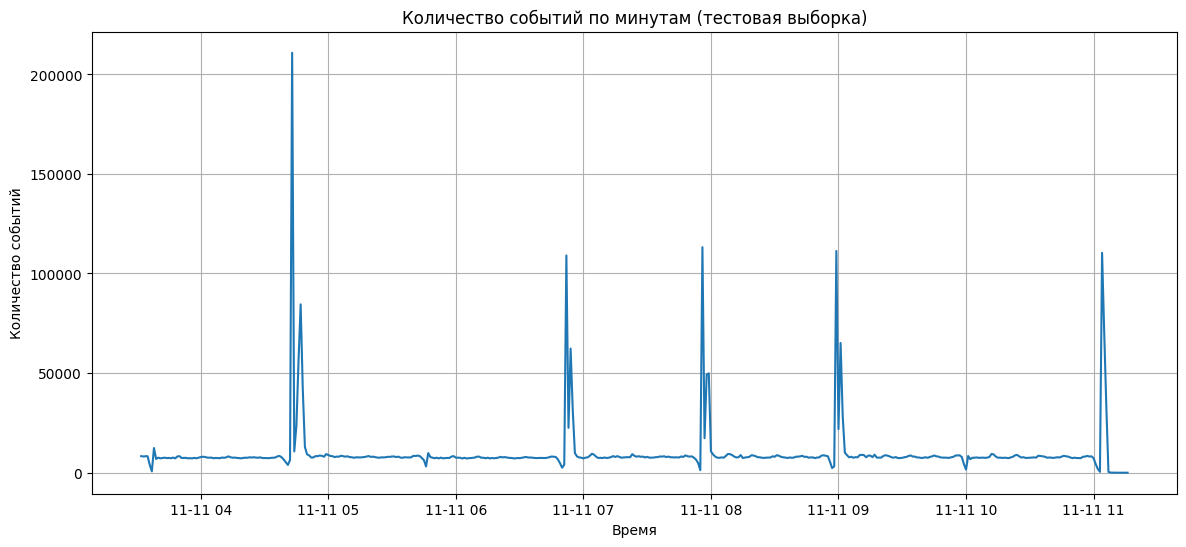

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.lineplot(
    data=test,
    x=test.index,
    y='full_log'
)

plt.title("Количество событий по минутам (тестовая выборка)")
plt.xlabel("Время")
plt.ylabel("Количество событий")
plt.grid(True)
plt.show()

Отметим аномальные минуты:

In [81]:
test["mark"] = "Normal"
test.loc[test["full_log"] > 8778.0, "mark"] = "Anomaly"

C:\Users\r.artyuhov\AppData\Local\Temp\ipykernel_2564\3936743853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["mark"] = "Normal"


In [92]:
test['mark'].value_counts()

mark
Normal     417
Anomaly     48
Name: count, dtype: int64

Accuracy представляет собой долю правильных предсказаний от общего количества предсказаний

Precision показывает долю правильно идентифицированных положительных случаев среди всех случаев, которые модель предсказала как положительные

Показатель Recall, также известный как чувствительность, полнота или True Positive Rate, показывает долю правильно идентифицированных положительных случаев от всех реально положительных случаев в данных

F1 Score представляет гармоническое среднее между precision и recall:
F1 = 2 * (Precision * Recall) / (Precision + Recall)

In [134]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


ts = pd.concat([train['full_log'], test['full_log']])


for k in range(1,5):
#    k = round(p * 0.1, 1)
    anomaly_target = []
    anomaly_forecast = []
    for s in range(len(train), len(train) + len(test) - 10 + 1,10):
        train_window = ts.iloc[s - 140:s]
        target = ts.iloc[s : s + 10]
        
        model = auto_arima(train_window)
        forecast = model.predict(n_periods=10)
        
        for i in range(10):
            mark = test['mark'].iloc[s + i - len(train)]
            if mark == 'Anomaly':
                anomaly_target.append(1)
            else:
                anomaly_target.append(0) 

        forecast_list = forecast.tolist()

        for i in range(10):
            actual_val = target.iloc[i]
            pred_val = forecast.iloc[i]
            anomaly_forecast.append(1 if actual_val > k * pred_val else 0)
    

    f1 = f1_score(anomaly_target, anomaly_forecast, zero_division=0)
    acc = accuracy_score(anomaly_target, anomaly_forecast)
    prec = precision_score(anomaly_target, anomaly_forecast, zero_division=0)
    rec = recall_score(anomaly_target, anomaly_forecast, zero_division=0)
    
    print(f"k={k} | F1 = {f1} | Accuracy = {acc} | Precision = {prec} | Recall = {rec}")

k=1 | F1 = 0.45454545454545453 | Accuracy = 0.8434782608695652 | Precision = 0.35714285714285715 | Recall = 0.625
k=2 | F1 = 0.5882352941176471 | Accuracy = 0.9391304347826087 | Precision = 1.0 | Recall = 0.4166666666666667
k=3 | F1 = 0.5230769230769231 | Accuracy = 0.9326086956521739 | Precision = 1.0 | Recall = 0.3541666666666667
k=4 | F1 = 0.45161290322580644 | Accuracy = 0.9260869565217391 | Precision = 1.0 | Recall = 0.2916666666666667


Ищем более точный коэффициент от 1 до 3

In [135]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


ts = pd.concat([train['full_log'], test['full_log']])


for p in range(10,30):
    k = round(p * 0.1, 1)
    anomaly_target = []
    anomaly_forecast = []
    for s in range(len(train), len(train) + len(test) - 10 + 1,10):
        train_window = ts.iloc[s - 140:s]
        target = ts.iloc[s : s + 10]
        
        model = auto_arima(train_window)
        forecast = model.predict(n_periods=10)
        
        for i in range(10):
            mark = test['mark'].iloc[s + i - len(train)]
            if mark == 'Anomaly':
                anomaly_target.append(1)
            else:
                anomaly_target.append(0) 

        forecast_list = forecast.tolist()

        for i in range(10):
            actual_val = target.iloc[i]
            pred_val = forecast.iloc[i]
            anomaly_forecast.append(1 if actual_val > k * pred_val else 0)
    

    f1 = f1_score(anomaly_target, anomaly_forecast, zero_division=0)
    acc = accuracy_score(anomaly_target, anomaly_forecast)
    prec = precision_score(anomaly_target, anomaly_forecast, zero_division=0)
    rec = recall_score(anomaly_target, anomaly_forecast, zero_division=0)
    
    print(f"k={k} | F1 = {f1} | Accuracy = {acc} | Precision = {prec} | Recall = {rec}")

k=1.0 | F1 = 0.45454545454545453 | Accuracy = 0.8434782608695652 | Precision = 0.35714285714285715 | Recall = 0.625
k=1.1 | F1 = 0.6666666666666666 | Accuracy = 0.941304347826087 | Precision = 0.8181818181818182 | Recall = 0.5625
k=1.2 | F1 = 0.6666666666666666 | Accuracy = 0.9456521739130435 | Precision = 0.9259259259259259 | Recall = 0.5208333333333334
k=1.3 | F1 = 0.6575342465753424 | Accuracy = 0.9456521739130435 | Precision = 0.96 | Recall = 0.5
k=1.4 | F1 = 0.6388888888888888 | Accuracy = 0.9434782608695652 | Precision = 0.9583333333333334 | Recall = 0.4791666666666667
k=1.5 | F1 = 0.6285714285714286 | Accuracy = 0.9434782608695652 | Precision = 1.0 | Recall = 0.4583333333333333
k=1.6 | F1 = 0.6086956521739131 | Accuracy = 0.941304347826087 | Precision = 1.0 | Recall = 0.4375
k=1.7 | F1 = 0.6086956521739131 | Accuracy = 0.941304347826087 | Precision = 1.0 | Recall = 0.4375
k=1.8 | F1 = 0.5882352941176471 | Accuracy = 0.9391304347826087 | Precision = 1.0 | Recall = 0.4166666666666

Оптимальные k = 1.2 или k = 1.1